# Research project - Distributed deep learning with Pythorch

## Local version

### AI Specialization University Minuto de Dios

#### Made by: Michael Andrés Mora Poveda

Objective:

The aim of this notebook is apply convolutional neural networks to train a multiclassifier with CIFAR-10 dataset 
in local version and with Pytorch deep learning framework. Moreover, it's important taking into account that other
purpose is calculate the time processing to contrast it with on-cloud distributed version on Azure.

All the descriptions and explanations about this dataset could be find in the following url:

**https://www.cs.toronto.edu/~kriz/cifar.html**


##### 1. Import the respective packages and initialize the dask cluster:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import time
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from dask_yarn import YarnCluster
from dask.distributed import Client
import dask.array as da
import time
import numpy as np

cluster = YarnCluster()
client = Client(cluster)

/opt/conda/miniconda3/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/opt/conda/miniconda3/lib/python3.8/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (
23/08/12 17:47:02 INFO client.RMProxy: Connecting to ResourceManager at mike-bq-test1-m/10.164.0.11:8032
23/08/12 17:47:02 INFO client.AHSProxy: Connecting to Application History server at mike-bq-test1-m/10.164.0.11:10200
23/08/12 17:47:02 INFO skein.Driver: Driver started, listening on 45395
23/08/12 17:47:03 INFO conf.Configuration: resource-types.xml not found
23/08/12 17:47:03 INFO resource.ResourceUtils: Unable to find 'resource-types.xml'.
23/08/12 17:47:03 INFO skein.Driver: Uploading application resources to hdfs:

##### 2. Parameterize the transformations to normalize the images:

In [2]:
def transform_data():
    """
    Apply the Compose function to convert an image to tensor
    and normalize the MNIST pictures with mean and standard 
    deviation equal to 0.5

    Args: 
        None

    Returns:
        Pictures normalized.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform

##### 3. Import the dataset directly from Pytorch dataset module and apply the data loader function to save all the files into data folder and visualize any properties:

In [3]:
def load_cifar10():
    """
    Import, save and load the CIFAR dataset from Pythorch.datasets module.

    Args: 
        batch_size (int): Number of pictures to each batch.

    Returns:
        train_loader: Training set 
        test_loader: Testing set 
    """
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_data())
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_data())
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    print("Train set size: {} images".format(len(trainset)))
    print("Test set size: {} images".format(len(testset)))
    
    return trainloader, testloader

##### 4. Define the labels to each one of the categories and confirm the datasets size:

In [4]:
# Clases del CIFAR-10
classes = ('avion', 'automovil', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion')

In [5]:
load_cifar10()

Files already downloaded and verified
Files already downloaded and verified
Train set size: 50000 images
Test set size: 10000 images


(<torch.utils.data.dataloader.DataLoader at 0x7ff338ac9970>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff338ac9dc0>)

##### 5. Define the Net class to instantiate the convolutional neural network:

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


##### 6. Define the training function:

In [7]:
def train_cnn(cnn_model, trainloader, criterion, optimizer, num_epochs):
    """
    This function train our CNN.

    Args:
        cnn_model (Net): Our CNN model instantiate with Pytorch
        train_loader (DataLoader object): Training set normalized
        criterion (torch.nn object): Loss function
        optimizer(torch.optim object): Optimizer to backpropagation process
        num_epochs (int): Number of epochs to train our model

    Return:
        Print the results of each training epoch.    
    """
    
    start_time = time.time()

    num_epochs = 90

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)  # Obtén las clases predichas


            # print statistics
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)  # El tamaño del lote (batch)

        epoch_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs} : [==============================] - Loss: {running_loss:.4f} - Accuracy: {epoch_accuracy:.4f}')
    
    print('Finished Training')

    end_time = time.time()
    execution_time2 = (end_time - start_time) / 60
    execution_time = end_time - start_time
    print(f"Tiempo de ejecución: {execution_time:.6f} seconds")
    print(f"Tiempo de ejecución: {execution_time2:.6f} minutes")


##### 7. Train the model with 90 epochs through main function:

In [8]:
def main():
    """
    Apply each function defined previously to our CNN model:
    """ 

     # Instantiate the datasets and dataloaders:
    train_loader, test_loader = load_cifar10()

    # Visualize any properties:
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    num_batches = len(train_loader)
    print("Total batches to training:", num_batches)
    
    # Pictures and label shapes:
    print("Pictures shape:", images.shape)
    print("Labels column shape:", labels.shape)

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    num_batches = len(test_loader)
    print("Total batches to testing:", num_batches)
    
    # Pictures and label shapes:
    print("Pictures shape:", images.shape)
    print("Labels column shape:", labels.shape)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    train_cnn(cnn_model=Net(), trainloader=train_loader, criterion=criterion, optimizer=optimizer, num_epochs=90)
    

In [9]:
if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Train set size: 50000 images
Test set size: 10000 images
Total batches to training: 391
Pictures shape: torch.Size([128, 3, 32, 32])
Labels column shape: torch.Size([128])
Total batches to testing: 79
Pictures shape: torch.Size([128, 3, 32, 32])
Labels column shape: torch.Size([128])
Epoch 1/90 : [==============================] - Loss: 900.4982 - Accuracy: 0.1061
Epoch 2/90 : [==============================] - Loss: 897.8714 - Accuracy: 0.1171
Epoch 3/90 : [==============================] - Loss: 879.4825 - Accuracy: 0.1841
Epoch 4/90 : [==============================] - Loss: 806.0545 - Accuracy: 0.2619
Epoch 5/90 : [==============================] - Loss: 752.7734 - Accuracy: 0.3052
Epoch 6/90 : [==============================] - Loss: 714.8234 - Accuracy: 0.3391
Epoch 7/90 : [==============================] - Loss: 676.4418 - Accuracy: 0.3696
Epoch 8/90 : [==============================] - Loss: 646.6190 - 

##### 8. Visualize a couple of pictures:

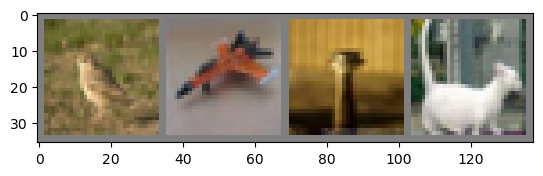

pajaro avion pajaro gato 


In [16]:
import random

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_data())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_data())
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)    

# Obtener 4 índices aleatorios para seleccionar imágenes
random_indices = random.sample(range(len(trainset)), 4)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Obtener las imágenes y etiquetas correspondientes a los índices aleatorios
random_images = [trainset[i][0] for i in random_indices]
random_labels = [trainset[i][1] for i in random_indices]

# Mostrar las 4 imágenes aleatorias
imshow(torchvision.utils.make_grid(random_images))
# Imprimir etiquetas de las imágenes aleatorias
print(' '.join(f'{classes[random_labels[j]]:5s}' for j in range(4)))

##### 9. Save the model in our local folder:

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

##### 10. Load the model to testing and visualize any results:

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

# Obtener las etiquetas predichas para las imágenes aleatorias
predicted_labels = [predicted[j] for j in range(4)]

# Imprimir las etiquetas predichas
print('Predicted: ', ' '.join(f'{classes[predicted_labels[j]]:5s}'
                              for j in range(4)))


Predicted:  rana  camion camion ciervo


In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: avion is 66.3 %
Accuracy for class: automovil is 82.0 %
Accuracy for class: pajaro is 42.6 %
Accuracy for class: gato  is 51.6 %
Accuracy for class: ciervo is 49.9 %
Accuracy for class: perro is 54.6 %
Accuracy for class: rana  is 73.9 %
Accuracy for class: caballo is 65.6 %
Accuracy for class: barco is 76.7 %
Accuracy for class: camion is 70.8 %


In [24]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
